In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
x_train = np.load('data/x_train_undersampled.npy')
y_train = np.load('data/y_train_undersampled.npy')
x_test = np.load('data/x_test_undersampled.npy')
y_test = np.load('data/y_test_undersampled.npy')

In [3]:
from __future__ import print_function

import numpy as np
from random import shuffle
import time
import csv
from PIL import Image
import os
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import initializers
from keras.optimizers import SGD
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from keras.callbacks import CSVLogger
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
import sys
sys.path.insert(0,'..')
from utils import lossprettifier
from Classifier.VGG import *

C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\f

In [4]:
# for reproducibility
np.random.seed(3768)

# use this environment flag to change which GPU to use 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

#Get TensorFlow session
def get_session(): 
  config = tf.ConfigProto() 
  config.gpu_options.allow_growth = True 
  return tf.Session(config=config) 
  
# One hot encoding of labels 
def dense_to_one_hot(labels_dense,num_clases=4):
  return np.eye(num_clases)[labels_dense]

In [5]:
# Preparing training and test sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [6]:
y_train = dense_to_one_hot(y_train,num_clases=3)
y_valid= dense_to_one_hot(y_valid,num_clases=3)

In [7]:
#Image data generation for the training 
datagen = ImageDataGenerator(
               featurewise_center = False, 
               samplewise_center = False,  # set each sample mean to 0
               featurewise_std_normalization = True,  
               samplewise_std_normalization = False)  

datagen.fit(x_train) 
for i in range(len(x_test)):
      x_test[i] = datagen.standardize(x_test[i])

C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\keras_preprocessing\image\image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [8]:
#Defining hyperparameters
batch_Size = 32
steps_Per_Epoch = 32
numEpochs = 50

#Instantating VGG19 model
model = VGG19((224,224,3),classes=3) #VGG19_dense for revised VGG19, VGG19 for VGG19. Please pay attention to VGG16(), chnage the input shape and class number in VGG.py.

#Creating an optimizers
adaDelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer = sgd , loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Creating early stopping 
earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 50, verbose = 1, mode = 'auto', restore_best_weights = True)       

train_generator = datagen.flow(x_train, y_train, batch_size = batch_Size)
validation_generator = datagen.flow(x_valid, y_valid, batch_size = batch_Size)

# Model training
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_Per_Epoch,
    validation_data = validation_generator, 
    validation_steps = 16,
    epochs = numEpochs,
    shuffle = True, 
    verbose = 1)



Epoch 1/50
32/32 [==============================] - 5s 150ms/step - loss: 1.0877 - accuracy: 0.3936 - val_loss: 1.0791 - val_accuracy: 0.3992
Epoch 2/50
32/32 [==============================] - 2s 71ms/step - loss: 0.9877 - accuracy: 0.5459 - val_loss: 1.1144 - val_accuracy: 0.5988
Epoch 3/50
32/32 [==============================] - 3s 87ms/step - loss: 0.9590 - accuracy: 0.5446 - val_loss: 0.7243 - val_accuracy: 0.6048
Epoch 4/50
32/32 [==============================] - 2s 69ms/step - loss: 0.8763 - accuracy: 0.6182 - val_loss: 0.8785 - val_accuracy: 0.6587
Epoch 5/50
32/32 [==============================] - 2s 71ms/step - loss: 0.8549 - accuracy: 0.6240 - val_loss: 0.7456 - val_accuracy: 0.6607
Epoch 6/50
32/32 [==============================] - 3s 83ms/step - loss: 0.8284 - accuracy: 0.6690 - val_loss: 0.7598 - val_accuracy: 0.6766
Epoch 7/50
32/32 [==============================] - 2s 69ms/step - loss: 0.7783 - accuracy: 0.6621 - val_loss: 1.5614 - val_accuracy: 0.6607
Epoch 8/50

In [9]:
modelPath = "VGG19_COVID19-v2.h5"
resultPath = 'VGG19_COVID19-v2.txt'
modelPath = 'tmp_model'

In [10]:
y_test_oh = dense_to_one_hot(y_test, num_clases=3)

# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Observing the losses but can be commented out as it's not mandatory 
reporter = lossprettifier.LossPrettifier(show_percentage=True)

for i in range(numEpochs-1):
    reporter(epoch=i, LossA = train_loss[i], LossAB = val_loss[i])

# Model evaluation 
score, acc = model.evaluate(x_test, y_test_oh, batch_size=batch_Size)
print("Accuracy:", acc)

#if acc>0.675:
model.save_weights(modelPath)
model.save(modelPath)

Epoch     0 | LossA: 1.09(+0.00%) 	| LossAB: 1.08(+0.00%) 	
Epoch     1 | LossA: 0.99(-9.19%) ▼	| LossAB: 1.11(+3.27%) ▲	
Epoch     2 | LossA: 0.96(-2.92%) ▼	| LossAB: 0.72(-35.01%) ▼	
Epoch     3 | LossA: 0.88(-8.61%) ▼	| LossAB: 0.88(+21.29%) ▲	
Epoch     4 | LossA: 0.85(-2.44%) ▼	| LossAB: 0.75(-15.12%) ▼	
Epoch     5 | LossA: 0.83(-3.11%) ▼	| LossAB: 0.76(+1.90%) ▲	
Epoch     6 | LossA: 0.78(-6.05%) ▼	| LossAB: 1.56(+105.50%) ▲	
Epoch     7 | LossA: 0.86(+10.05%) ▲	| LossAB: 0.83(-46.93%) ▼	
Epoch     8 | LossA: 0.80(-7.00%) ▼	| LossAB: 0.57(-31.19%) ▼	
Epoch     9 | LossA: 0.78(-1.88%) ▼	| LossAB: 0.69(+21.09%) ▲	
Epoch    10 | LossA: 0.69(-11.53%) ▼	| LossAB: 0.61(-11.58%) ▼	
Epoch    11 | LossA: 0.72(+3.94%) ▲	| LossAB: 0.72(+18.34%) ▲	
Epoch    12 | LossA: 0.69(-4.49%) ▼	| LossAB: 0.61(-15.21%) ▼	
Epoch    13 | LossA: 0.67(-2.98%) ▼	| LossAB: 0.65(+5.81%) ▲	
Epoch    14 | LossA: 0.71(+6.68%) ▲	| LossAB: 0.90(+38.91%) ▲	
Epoch    15 | LossA: 0.77(+7.72%) ▲	| LossAB: 0.71(-21.14%

In [11]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(len(y_test), 3)
y_pred = np.argmax(y_pred, axis=1)

## Confusion matrix

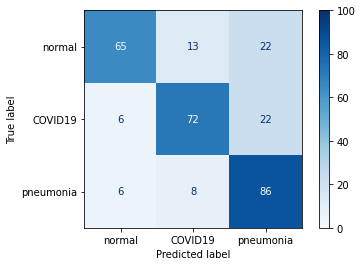

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['normal', 'COVID19', 'pneumonia']))
disp.plot(cmap='Blues') 
disp.ax_.get_images()[0].set_clim(0, 100)

## Precyzja, czułość, F1, dokładność

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.65      0.73       100
           1       0.77      0.72      0.75       100
           2       0.66      0.86      0.75       100

    accuracy                           0.74       300
   macro avg       0.76      0.74      0.74       300
weighted avg       0.76      0.74      0.74       300



## Swoistość

Wyliczenie wszystkich podstawowych metryk z confusion matrix (w tym swoistość, czyli TNR).

In [14]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [15]:
ACC

array([0.84333333, 0.83666667, 0.80666667])

In [16]:
print(TNR)

[0.94  0.895 0.78 ]


## ROC i AUC

In [17]:
def dense_to_one_hot(labels_dense,num_clases=3):
  return np.eye(num_clases)[labels_dense]

In [18]:
y_test1 = dense_to_one_hot(y_test)
y_pred1 = dense_to_one_hot(y_pred)

In [19]:
from sklearn.metrics import roc_curve, auc

n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

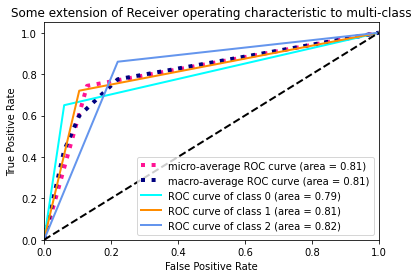

In [20]:
import matplotlib.pyplot as plt
from itertools import cycle

lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.rcParams["figure.figsize"] = (7,6)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Współczynnik Giniego

In [21]:
def gini_coeff(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

In [22]:
n_classes = 3

gini = dict()
for i in range(n_classes):
    gini[i] = gini_coeff(y_test1[:, i], y_pred1[:, i])

In [23]:
gini

{0: 0.19666666666666666, 1: 0.31373333333333336, 2: 0.11386666666666666}

In [24]:
gini_coeff(y_test, y_pred)

0.10464444444444448

## Cohen Kappa

In [25]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred))

0.615
